---
title: "linear mixed effect model"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

A mixed effect model is an expansion of the ordinary linear regression model that includes both fixed effects and random effects. The fixed effects are the same as in a standard linear regression (could be with or without interactions), while the random effects account for variability across different groups or clusters in the data.

## practical example

We are given a dataset of annual income (independent variable) and years of education (independent variable) for individuals that studied different majors in university (categorical variable). We want to predict the annual income based on years of education and the major studied, including an interaction term between years of education and major. One more thing: each individual appears more than once in the dataset, so we can assume that there is a random effect associated with each individual.

In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

In [2]:
#| code-summary: "generate synthetic data"
# set seed for reproducibility
np.random.seed(42)
# define parameters
majors = ['Juggling', 'Magic', 'Dragon Taming']
n_individuals = 90  # 30 per major
years_per_person = np.random.randint(1, 5, size=n_individuals)  # 1 to 4 time points

# assign majors and person IDs
person_ids = [f'P{i+1:03d}' for i in range(n_individuals)]
major_assignment = np.repeat(majors, n_individuals // len(majors))

# simulate data
records = []
for i, pid in enumerate(person_ids):
    major = major_assignment[i]
    n_years = years_per_person[i]
    years = np.sort(np.random.choice(np.arange(1, 21), size=n_years, replace=False))
    
    # base intercept and slope by major
    if major == 'Juggling':
        base_income = 25_000
        growth = 800
    elif major == 'Magic':
        base_income = 20_000
        growth = 1500
    elif major == 'Dragon Taming':
        base_income = 30_000
        growth = 400  # slower growth
    
    # add person-specific deviation
    personal_offset = np.random.normal(0, 5000)
    slope_offset = np.random.normal(0, 200)
    
    for y in years:
        income = base_income + personal_offset + (growth + slope_offset) * y + np.random.normal(0, 3000)
        records.append({
            'person': pid,
            'major': major,
            'years_after_grad': y,
            'income': income
        })

df = pd.DataFrame(records)

Let's take a look at the dataset. There are many data points, so we will only see 15 points in three different places.

In [3]:
print(df[:5])
print(df[90:95])
print(df[190:195])

  person     major  years_after_grad        income
0   P001  Juggling                 3  37183.719609
1   P001  Juggling                 5  35238.112407
2   P001  Juggling                11  37905.435001
3   P002  Juggling                 2  27432.186391
4   P002  Juggling                 4  30617.926804
   person  major  years_after_grad        income
90   P034  Magic                 1  14151.072305
91   P034  Magic                 7  19716.656861
92   P035  Magic                12  41056.576643
93   P035  Magic                14  46339.987229
94   P036  Magic                16  41981.131518
    person          major  years_after_grad        income
190   P072  Dragon Taming                 7  36173.437735
191   P073  Dragon Taming                 8  33450.564557
192   P074  Dragon Taming                 9  35276.927416
193   P074  Dragon Taming                17  37271.203018
194   P075  Dragon Taming                 2  31819.051946


Now let's see the data in a plot.

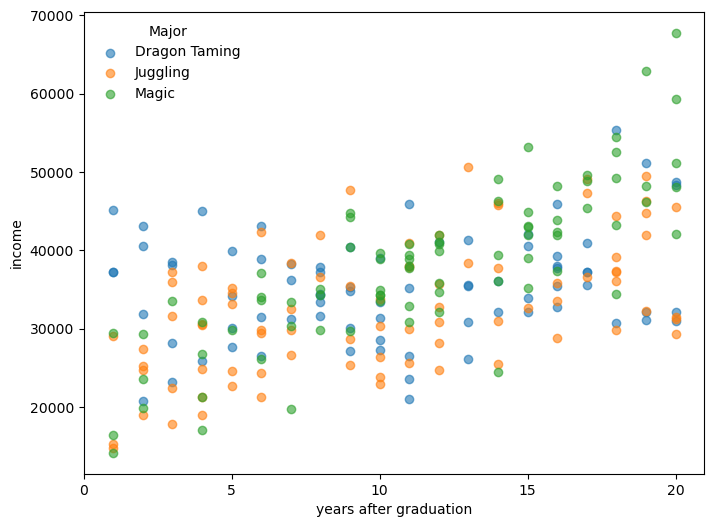

In [4]:
#| code-summary: "plot income by major"
fig, ax = plt.subplots(figsize=(8, 6))

gb = df.groupby('major')
for major, group in gb:
    ax.scatter(group['years_after_grad'], group['income'], label=major, alpha=0.6)

ax.legend(title='Major', frameon=False)
ax.set(xlabel='years after graduation',
       ylabel='income',
       xticks=np.arange(0, 21, 5)
       );

The model we will use is

$$
y = \underbrace{X \beta}_{\text{fixed effects}} + \underbrace{Z b}_{\text{random effects}} + \underbrace{\varepsilon}_{\text{residuals}}
$$

The only new term here is $Zb$, the random effects, where $Z$ is the design matrix for the random effects and $b$ is the vector of random effects coefficients. We will discuss that a bit later. Let's start with the fixed effects part:

$$
X \beta = \beta_0 + \beta_1 \cdot \text{years} + \beta_2 \cdot \text{major} + \beta_3 \cdot (\text{years} \cdot \text{major})
$$

The "years" variable is continuous, while the "major" variable is categorical. How to include categorical variables in a linear regression model? We can use dummy coding, where we create binary variables for each category of the categorical variable (except one category, which serves as the reference group). In our case, we have three majors: Juggling, Magic, and Dragon Taming. Let's use "Juggling" as the reference group. We can create two dummy variables that function as toggles.

- `major_Magic`: 1 if the major is Magic, 0 otherwise
- `major_DragonTaming`: 1 if the major is Dragon Taming, 0 otherwise

## visualizing categories as toggles

In the equation above, we have only one parameter for "major" ($\beta_2$), and only one parameter for the interaction terms ($\beta_3$). In reality we have more, see:

\begin{align*}
\text{income} &= \beta_0 + \beta_1 \cdot \text{years} \\
&+ \beta_2 \cdot \text{major\_Magic} + \beta_3 \cdot \text{major\_DragonTaming} \\
&+ \beta_4 \cdot (\text{years} \cdot \text{major\_Magic}) + \beta_5 \cdot (\text{years} \cdot \text{major\_DragonTaming}) \\
&+ \epsilon
\end{align*}

The first line represents the linear relationship between income and education of the reference group (Juggling). The second line adds the effects on the intercept of having studied Magic or Dragon Taming instead, and the third line adds the the effects on the slope of these two majors.

Let's see for a few data points how this works. Below, dummy variables represent the pair (major_Magic, major_DragonTaming).

| years_after_grad | major           | Dummy variables  | income   |
|------------------|-----------------|------------------|----------|
| 3                | Juggling        | (0, 0)           | 37183.72 |
| 5                | Magic           | (1, 0)           | 35101.07 |
| 7                | Dragon Taming   | (0, 1)           | 27179.77 |
| 10               | Juggling        | (0, 0)           | 26366.80 |
| 12               | Magic           | (1, 0)           | 26101.53 |
| 16               | Dragon Taming   | (0, 1)           | 39252.76 |

The design matrix $X$ would look like this:

$$
X = 
\begin{array}{c}
  \begin{array}{cccccc}
    \beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5
  \end{array} \\
  \begin{pmatrix}
    1 & 3 & 0 & 0 & 0 & 0 \\
    1 & 5 & 1 & 0 & 5 & 0 \\
    1 & 7 & 0 & 1 & 0 & 7 \\
    1 & 10 & 0 & 0 & 0 & 0 \\
    1 & 12 & 1 & 0 & 12 & 0 \\
    1 & 16 & 0 & 1 & 0 & 16
  \end{pmatrix}
\end{array}.
$$

The betas above the matrix are there just to label the columns, they are not really part of the matrix. The 3rd and 4th columns are the dummy variables for the majors, and the 5th and 6th columns are the interaction terms between education and the majors.

If we were not interested in the random effects, we could stop here, and just use the ordinary least squares (OLS) method already discussed to estimate the coefficients $\beta$.

## random effects

Conceptually, the random effects function in a very similar way to the fixed effects. Instead of a small number of categories, now each person in the dataset is a category. In our example we have 90 different people represented in the dataset, so the quantity $Z$ in $Zb$ is the design matrix for the random effects, which is a matrix with 90 columns, one for each person, and as many rows as there are data points in the dataset. Each row has a 1 in the column corresponding to the person, and 0s elsewhere. The vector $b$ is a vector of random effects coefficients, one for each person.

## implementation

We can use `statsmodels` function `smf.mixedlm` to do everything for us. We just need to specify the formula, which includes the interaction term, and the data.

If you don't mind which category is the reference group, you can skip the cell below. If you want to make sure a give one is the reference group (Juggling in our case), then you should run it. 

In [5]:
#| code-summary: "choose Juggling as reference major"
from pandas.api.types import CategoricalDtype
# define the desired order: Juggling as reference
major_order = CategoricalDtype(categories=["Juggling", "Magic", "Dragon Taming"], ordered=True)
df["major"] = df["major"].astype(major_order)

The syntax is fairly economic. The formula

`income ~ years_after_grad * major`

specifies a linear model where both the baseline income (intercept) and the effect of time since graduation (slope) can vary by major. The * operator includes both the main effects (years after graduation and major) and their interaction, allowing the model to fit a different intercept and slope for each major.

In the line

`model = smf.mixedlm(formula, data=df, groups=df["person"])`

the `groups` argument specifies that the random effects are associated with the "person" variable, meaning that each person can have their own random intercept.

In [6]:
#| code-summary: "coding the model"
#| code-fold: false
# formula with interaction
formula = "income ~ years_after_grad * major"

# fit mixed model with random intercept for person
model = smf.mixedlm(formula, data=df, groups=df["person"])
result = model.fit()

Let's see the results

In [7]:
#| code-summary: "view summary"
#| code-fold: false
print(result.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            income       
No. Observations:              239                Method:                        REML         
No. Groups:                    90                 Scale:                         10690821.7105
Min. group size:               1                  Log-Likelihood:                -2327.5068   
Max. group size:               4                  Converged:                     Yes          
Mean group size:               2.7                                                            
----------------------------------------------------------------------------------------------
                                           Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
----------------------------------------------------------------------------------------------
Intercept                                  25206.095 1349.760 18.675 0.000 2256

## interpreting the results

To interpret the coefficients, start with the reference group, which in this model is someone who studied Juggling. Their predicted income is:

$$
\text{income} = 25206.10 + 723.75 \times \text{years}
$$

Now, for a person who studied Magic, the model **adjusts** both the intercept and the slope:

Intercept shift: -2999.75
Slope shift: +635.18
So for Magic, the predicted income becomes:

\begin{align*}
\text{income} &= (25206.10 - 2999.75) + (723.75 + 635.18) \times \text{years} \\
       &= 22206.35 + 1358.93 \times \text{years}
\end{align*}

This means that compared to Jugglers, Magicians start with a lower baseline salary, but their income grows much faster with each year after graduation.

The `Coef.` column shows the estimated value of each parameter (e.g., intercepts, slopes, interactions). The `Std.Err.` column reports the standard error of the estimate, reflecting its uncertainty. The `z` column is the test statistic (estimate divided by standard error), and `P>|z|` gives the p-value, which helps assess whether the effect is statistically significant. The final two columns, `[0.025 and 0.975]`, show the 95% confidence interval for the coefficient — if this interval does not include zero, the effect is likely meaningful.

The line labeled `Group Var` shows the estimated variance of the random intercepts — in this case, variation in baseline income between individuals. The second number reported is the standard error associated with this estimate, which indicates how much uncertainty there is in the estimate of the variance.

If you like, you can print out all the variances for the random effects. They are not explicity shown in the summary, but you can access them through the model's `random_effects` attribute:

`result.random_effects`

Finally, the model as is does not include random slopes, meaning that the effect of years after graduation is assumed to be the same for all individuals. If you want to allow for different slopes for each individual, you can modify the model to include random slopes as well. This would require changing the formula and the `groups` argument accordingly. Also, `result.random_effects` will then contain not only the random intercepts, but also the random slopes for each individual.

In [8]:
#| code-summary: "modify model with random slope"
#| code-fold: false
model = smf.mixedlm(
    "income ~ years_after_grad * major",
    data=df,
    groups=df["person"],
    re_formula="~years_after_grad"
)
result = model.fit()
print(result.summary())

/Users/yairmau/miniforge3/envs/olympus/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yairmau/miniforge3/envs/olympus/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                            Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            income       
No. Observations:              239                Method:                        REML         
No. Groups:                    90                 Scale:                         10125672.1682
Min. group size:               1                  Log-Likelihood:                -2323.7559   
Max. group size:               4                  Converged:                     Yes          
Mean group size:               2.7                                                            
----------------------------------------------------------------------------------------------
                                           Coef.     Std.Err.   z    P>|z|   [0.025    0.975] 
----------------------------------------------------------------------------------------------
Intercept                                  25133.841 1208.050 20.805 0.000 2276

## back to OLS

If you went this far, and now realized you don't care about random effects, you can just use the `statsmodels` function `smf.ols` to fit an ordinary least squares regression model. The syntax is similar, but without the `groups` argument.

In [9]:
#| code-summary: "run OLS model"
#| code-fold: false
import statsmodels.formula.api as smf

# formula with main effects and interaction
formula = "income ~ years_after_grad * major"

# fit the model with OLS (no random effects)
ols_model = smf.ols(formula, data=df)
ols_result = ols_model.fit()

# print summary
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     38.85
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           6.27e-29
Time:                        16:16:38   Log-Likelihood:                -2437.0
No. Observations:                 239   AIC:                             4886.
Df Residuals:                     233   BIC:                             4907.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------